In [ ]:
import numpy as np
import pandas as pd

# Load datasets
df = pd.read_csv('/content/train_lending_club.csv')
df_test = pd.read_csv('/content/test_lending_club.csv')

print("Train rows:", len(df))
print("Test rows:", len(df_test))


Train rows: 236846
Test rows: 95019


In [ ]:
from scipy import stats

numeric_cols = df.select_dtypes(include=np.number).columns
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df1 = df[(z_scores < 3).all(axis=1)]

print("Rows before:", len(df))
print("Rows after removing outliers:", len(df1))


Rows before: 236846
Rows after removing outliers: 212713


In [ ]:
df1["fico_score"] = (df1["fico_range_low"] + df1["fico_range_high"]) / 2
df1 = df1.drop(["fico_range_low", "fico_range_high"], axis=1)

df_test["fico_score"] = (df_test["fico_range_low"] + df_test["fico_range_high"]) / 2
df_test = df_test.drop(["fico_range_low", "fico_range_high"], axis=1)

print(df1[["fico_score"]].head())


   fico_score
0       662.0
1       742.0
2       702.0
3       667.0
4       702.0


/tmp/ipython-input-3433303211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["fico_score"] = (df1["fico_range_low"] + df1["fico_range_high"]) / 2


In [ ]:
keep_cols = [
    'sub_grade', 'fico_score', 'annual_inc', 'mort_acc',
    'initial_list_status', 'time_to_earliest_cr_line', 'emp_length',
    'revol_bal', 'term', 'home_ownership', 'revol_util', 'dti',
    'int_rate', 'loan_amnt', 'verification_status'
]

df_selected = df1[keep_cols + ['loan_status']]
df_test1 = df_test[keep_cols + ['loan_status']]

print("Train shape:", df_selected.shape)
print("Test shape:", df_test1.shape)


Train shape: (212713, 16)
Test shape: (95019, 16)


In [ ]:
categorical_cols = [
    "sub_grade", "term", "home_ownership",
    "verification_status", "initial_list_status"
]

for col in categorical_cols:
    df_selected[col] = df_selected[col].astype("category")
    df_test1[col] = df_test1[col].astype("category")


/tmp/ipython-input-4165470397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = df_selected[col].astype("category")
/tmp/ipython-input-4165470397.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1[col] = df_test1[col].astype("category")
/tmp/ipython-input-4165470397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [ ]:
df_selected = df_selected.dropna(subset=['loan_status'])
df_test1 = df_test1.dropna(subset=['loan_status'])


In [ ]:
# Split features/target
target = "loan_status"
features = [col for col in keep_cols]

X = df_selected[features].copy()
y = df_selected[target].copy()
X_test = df_test1[features].copy()
y_test = df_test1[target].copy()

# Debt-to-income & available revol credit
X['debt_to_income'] = X['loan_amnt'] / X['annual_inc']
X_test['debt_to_income'] = X_test['loan_amnt'] / X_test['annual_inc']

X['available_revol_credit'] = X['revol_bal'] / (X['revol_util'] + 1e-6)
X_test['available_revol_credit'] = X_test['revol_bal'] / (X_test['revol_util'] + 1e-6)

# Drop original columns
drop_cols = ['loan_amnt', 'annual_inc', 'revol_bal', 'revol_util']
X = X.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

# Update numeric features list
numeric_features = ['fico_score', 'mort_acc', 'time_to_earliest_cr_line', 'emp_length',
                    'dti', 'int_rate', 'debt_to_income', 'available_revol_credit']


In [ ]:
X = X.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill numeric NaNs with median
X = X.fillna(X.median(numeric_only=True))
X_test = X_test.fillna(X_test.median(numeric_only=True))


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import ADASYN
import numpy as np
import pandas as pd

# One-hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # <-- changed here
X_cat = ohe.fit_transform(X[categorical_cols])

# Combine with numeric features
X_num = X[numeric_features].values
X_numeric_full = np.hstack([X_num, X_cat])

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_numeric_full, y)

print("Original class distribution:\n", y.value_counts())
print("After ADASYN:\n", pd.Series(y_res).value_counts())


Original class distribution:
 loan_status
1    177280
0     35433
Name: count, dtype: int64
After ADASYN:
 loan_status
0    178772
1    177280
Name: count, dtype: int64


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_features)
    ]
)


In [ ]:
def lgb_weighted_bce(y_true, y_pred):
    y_pred_sigmoid = 1 / (1 + np.exp(-y_pred))  # sigmoid
    grad = (y_pred_sigmoid - y_true) * np.where(y_true == 1, 5.0, 1.0)
    hess = y_pred_sigmoid * (1 - y_pred_sigmoid) * np.where(y_true == 1, 5.0, 1.0)
    return grad, hess


In [ ]:
def xgb_weighted_logloss(y_true, y_pred):
    preds = 1 / (1 + np.exp(-y_pred))  # sigmoid
    grad = (preds - y_true) * np.where(y_true == 1, 5.0, 1.0)
    hess = preds * (1 - preds) * np.where(y_true == 1, 5.0, 1.0)
    return grad, hess


In [ ]:
# LightGBM
lgbm_clf = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    num_leaves=31,
    objective=lgb_weighted_bce
)

# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    use_label_encoder=False,
    objective=xgb_weighted_logloss,
    eval_metric='logloss',
    random_state=42
)

# AdaBoost with sample weights
ada_clf = AdaBoostClassifier(
    n_estimators=200,
    random_state=42
)


In [ ]:
meta_clf = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)


In [ ]:
stack_model = StackingClassifier(
    estimators=[('lgbm', lgbm_clf), ('xgb', xgb_clf), ('ada', ada_clf)],
    final_estimator=meta_clf,
    stack_method='predict_proba',
    n_jobs=-1
)


In [ ]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('stack', stack_model)
])


In [ ]:
sample_weights = np.where(y == 1, 5.0, 1.0)


pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sub_grade', 'term',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'initial_list_status']),
                                                 ('num', StandardScaler(),
                                                  ['fico_score', 'mort_acc',
                                                   'time_to_earliest_cr_line',
                                                   'emp_length', 'dti',
                                                   'int_rate', 'debt_to_income',
                                                   'available_revol_credit'])])),
                ('st...
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('ada',
                                                 AdaBoostClassifier(n_estimators=200,
                                                                    random_state=42))],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000,
                                                                       random_state=42),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve

# Predict probabilities
test_preds = pipeline.predict_proba(X_test)[:, 1]

# Threshold that maximizes F1
precision, recall, thresholds = precision_recall_curve(y_test, test_preds)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_thresh = thresholds[np.argmax(f1_scores)]

# Apply threshold
test_preds_binary = (test_preds >= best_thresh).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, test_preds_binary)
auc = roc_auc_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds_binary)
precision_val = precision_score(y_test, test_preds_binary)
recall_val = recall_score(y_test, test_preds_binary)

# Print results
print("\n===== Test Results =====")
print(f"Optimal Threshold (F1 max): {best_thresh:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall:    {recall_val:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lightgbm/sklearn.py:1638: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning(



===== Test Results =====
Optimal Threshold (F1 max): 0.1139
Accuracy:  0.8949
AUC:       0.7969
F1 Score:  0.9151
Precision: 0.8491
Recall:    0.9923


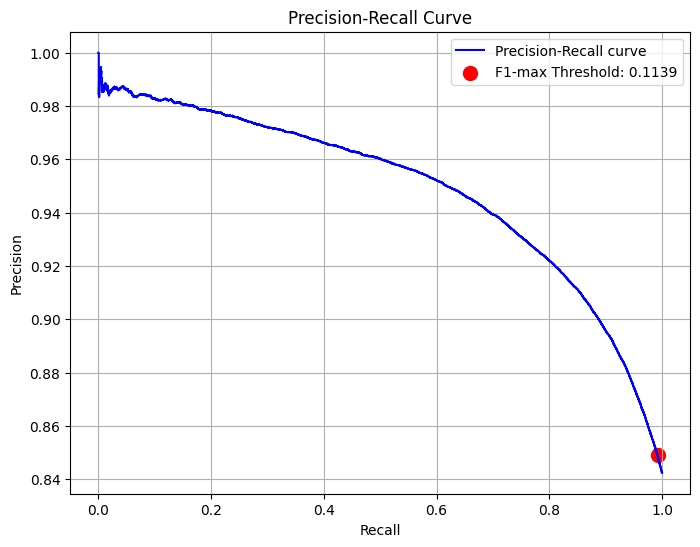

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, thresholds
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, test_preds)

# F1-maximizing threshold
best_idx = (2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-9)).argmax()
best_threshold = thresholds[best_idx]

# Plot
plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label="Precision-Recall curve", color="blue")
plt.scatter(recall_vals[best_idx], precision_vals[best_idx],
            color='red', label=f"F1-max Threshold: {best_threshold:.4f}", s=100)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

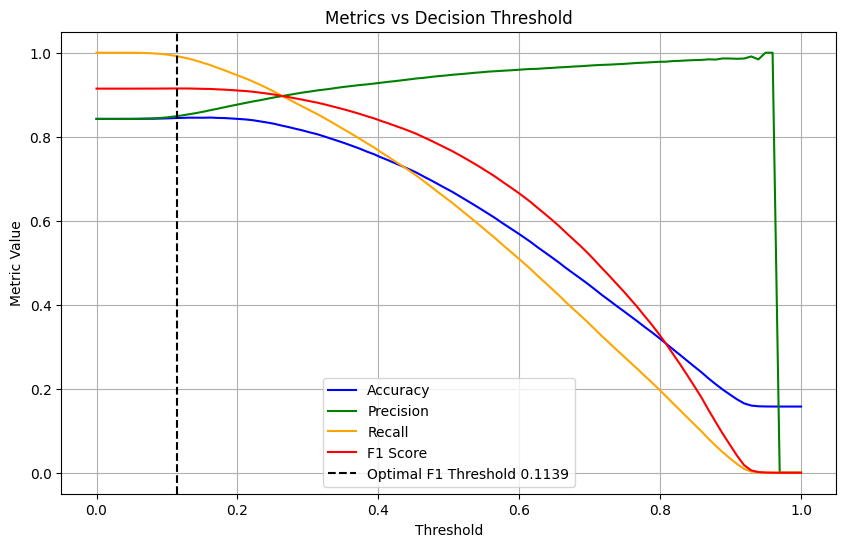

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Thresholds to evaluate
thresholds_all = np.linspace(0, 1, 100)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for t in thresholds_all:
    preds_bin = (test_preds >= t).astype(int)
    accuracy_list.append(accuracy_score(y_test, preds_bin))
    precision_list.append(precision_score(y_test, preds_bin))
    recall_list.append(recall_score(y_test, preds_bin))
    f1_list.append(f1_score(y_test, preds_bin))

# Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds_all, accuracy_list, label='Accuracy', color='blue')
plt.plot(thresholds_all, precision_list, label='Precision', color='green')
plt.plot(thresholds_all, recall_list, label='Recall', color='orange')
plt.plot(thresholds_all, f1_list, label='F1 Score', color='red')
plt.axvline(best_thresh, color='black', linestyle='--', label=f'Optimal F1 Threshold {best_thresh:.4f}')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()
